
# Exploratory Data Analysis ? Telecom Subscriber Dataset

This notebook explores the cleaned subscriber dataset to surface behavioral, financial, and experiential patterns that will inform downstream modeling and business recommendations.



## 0. Imports, configuration, and data load


In [1]:

import os
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
from scipy import stats
import folium

NOTEBOOK_CWD = Path(os.getcwd()).resolve()
PROJECT_ROOT = None
for candidate in [
    NOTEBOOK_CWD,
    NOTEBOOK_CWD.parent,
    NOTEBOOK_CWD.parent.parent,
    NOTEBOOK_CWD / 'data_science_project',
]:
    src_dir = (candidate / 'src').resolve()
    if src_dir.exists():
        PROJECT_ROOT = candidate.resolve()
        if str(PROJECT_ROOT) not in sys.path:
            sys.path.append(str(PROJECT_ROOT))
        break

if PROJECT_ROOT is None:
    raise RuntimeError('Could not locate project root from notebook directory.')

FIGURES_DIR = PROJECT_ROOT / 'reports' / 'figures'
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

from src.pipelines.preprocessing import run_pipeline  # noqa: E402

PROCESSED_PATH = PROJECT_ROOT / 'data' / 'processed' / 'clean_dataset.csv'
RAW_PATH = PROJECT_ROOT / 'data' / 'raw' / 'training_master_dataset.csv'

sns.set_theme(style='whitegrid', context='talk')
plt.rcParams['figure.figsize'] = (12, 6)

clean_df = pd.read_csv(PROCESSED_PATH, parse_dates=['signup_date', 'last_seen'])
clean_df.head()


customer_id signup_date  last_seen  age  gender            province  \
0            1  2020-08-15 2022-12-16   30    Male  Matabeleland North   
1            2  2024-08-27 2025-05-11   31    Male    Mashonaland West   
2            3  2023-02-14 2023-03-30   38    Male          Manicaland   
3            4  2022-03-11 2022-12-04   57  Female            Masvingo   
4            5  2019-02-03 2020-12-05   18    Male            Bulawayo   

       lat      lng plan_type        contract  ... defaulted_loan  \
0 -18.6203  27.6337   Prepaid  Month-to-Month  ...          False   
1 -17.2211  30.1817  Postpaid        One Year  ...          False   
2 -19.0543  32.5927  Postpaid  Month-to-Month  ...          False   
3 -20.5122  30.8098   Prepaid        One Year  ...          False   
4 -20.4335  28.6515   Prepaid  Month-to-Month  ...           True   

  next_month_spend                                        review_text  \
0            32.03         Fantastic experience from start to finish.   
1            43.09      Excellent! Fast, reliable, and great support.   
2            26.88      Excellent! Fast, reliable, and great support.   
3            20.44         Fantastic experience from start to finish.   
4            12.45  Pretty satisfied with the features for the price.   

   tenure_years  support_tickets_per_month  avg_monthly_revenue  \
0          2.33                      0.000            19.890000   
1          0.67                      0.167            42.280000   
2          0.08                      0.167            33.140000   
3          0.67                      0.167            19.198750   
4          1.83                      0.000            14.855455   

   spend_to_income_ratio  charges_per_gb  engagement_intensity  \
0               0.027611        4.845266                 42.33   
1               0.088129        4.814234                 16.74   
2               0.028691        2.143939                 29.46   
3               0.039658        1.307536                 38.40   
4               0.029844        3.683951                 25.90   

   lifetime_value_projection  
0                     941.28  
1                     855.32  
2                      33.14  
3                     153.59  
4                     476.22  

[5 rows x 37 columns]


### Shape and schema overview


In [2]:

print(f"Rows: {len(clean_df):,} | Columns: {len(clean_df.columns)}")
clean_df.info()


Rows: 20,000 | Columns: 37
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 37 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   customer_id                20000 non-null  int64         
 1   signup_date                20000 non-null  datetime64[ns]
 2   last_seen                  20000 non-null  datetime64[ns]
 3   age                        20000 non-null  int64         
 4   gender                     20000 non-null  object        
 5   province                   20000 non-null  object        
 6   lat                        20000 non-null  float64       
 7   lng                        20000 non-null  float64       
 8   plan_type                  20000 non-null  object        
 9   contract                   20000 non-null  object        
 10  payment_method             20000 non-null  object        
 11  device_type                20000 non-nul


### Summary statistics


In [3]:

numeric_summary = clean_df.select_dtypes(include='number').describe().T
numeric_summary[['mean', 'std', 'min', 'max']]


mean          std         min           max
customer_id                10000.500000  5773.647028    1.000000  20000.000000
age                           34.693000     9.568366   18.000000     77.000000
lat                          -18.879943     1.286645  -21.630600    -16.150700
lng                           30.314070     1.516392   26.792100     33.346700
tenure_months                 16.640550     9.975842    0.000000     36.000000
monthly_charges               30.953414    19.497333    5.000000     78.448750
total_charges                492.419049   415.599685    0.000000   1476.658750
support_tickets_last_6mo       0.895100     0.965320    0.000000      8.000000
data_usage_gb                  9.679016     5.166544    0.210000     23.278750
calls_per_month               43.921450     9.088818   19.000000     67.000000
messages_per_month            85.969650    10.397775   58.000000    114.000000
avg_session_minutes           26.442006     8.194696    4.600000     48.280000
credit_score                 620.514150    77.150079  418.500000    822.500000
income                      7185.738982  2944.598628  952.570000  14364.001250
late_payments                  0.515000     0.717914    0.000000      2.000000
satisfaction_score             4.761900     0.474046    2.000000      5.000000
next_month_spend              35.133422    21.608792    0.000000     85.651250
tenure_years                   1.386699     0.831409    0.000000      3.000000
support_tickets_per_month      0.149251     0.160848    0.000000      1.333000
avg_monthly_revenue           30.327173    18.987944    4.516923    129.696364
spend_to_income_ratio          0.061323     0.050714    0.004177      0.726041
charges_per_gb                 4.259670     4.659136    0.219010    190.333333
engagement_intensity          35.132634     8.336181   10.900000     59.780000
lifetime_value_projection    820.980665   591.368601    0.000000   2504.473750

In [4]:

category_counts = clean_df.select_dtypes(include='object').nunique().sort_values(ascending=False)
category_counts.to_frame('unique_categories')


unique_categories
review_text                    13
province                       10
payment_method                  5
plan_type                       3
gender                          3
contract                        3
device_type                     3


## 1. Missingness check


C:\Users\kkadema.SIRDC\AppData\Local\Temp\ipykernel_28184\1507735285.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing_pct.index, y=missing_pct.values * 100, ax=ax, palette='crest')


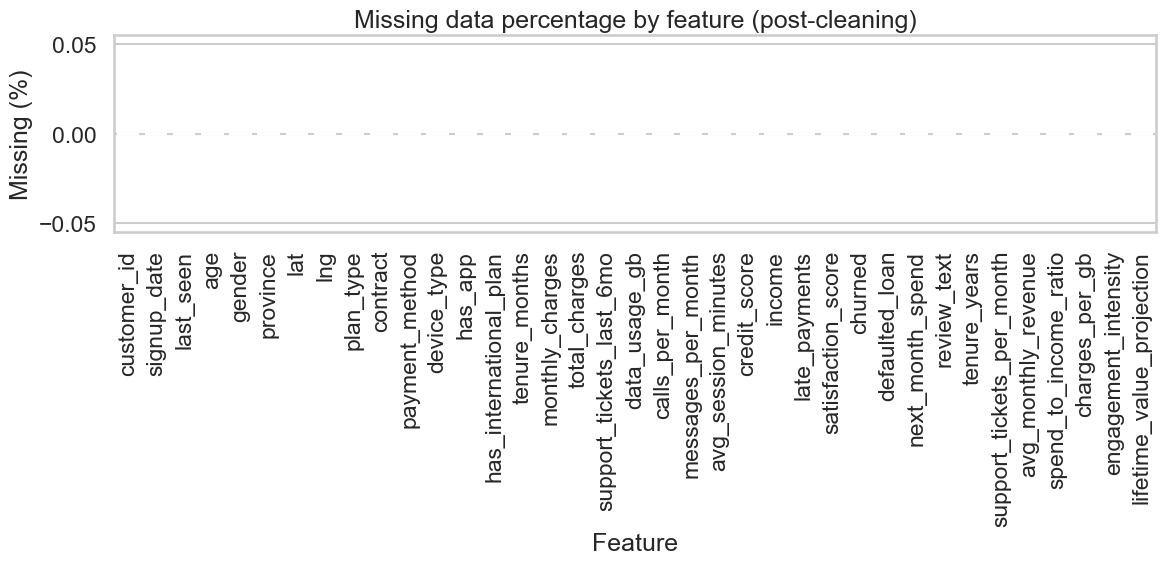

WindowsPath('C:/Users/kkadema.SIRDC/Desktop/data analysis/data_science_project/reports/figures/missingness_bar.png')

In [5]:

missing_pct = clean_df.isna().mean().sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x=missing_pct.index, y=missing_pct.values * 100, ax=ax, palette='crest')
ax.set_ylabel('Missing (%)')
ax.set_xlabel('Feature')
ax.set_title('Missing data percentage by feature (post-cleaning)')
ax.tick_params(axis='x', rotation=90)
plt.tight_layout()
fig_path = FIGURES_DIR / 'missingness_bar.png'
fig.savefig(fig_path, dpi=300)
plt.show()
fig_path



## 2. Univariate analysis


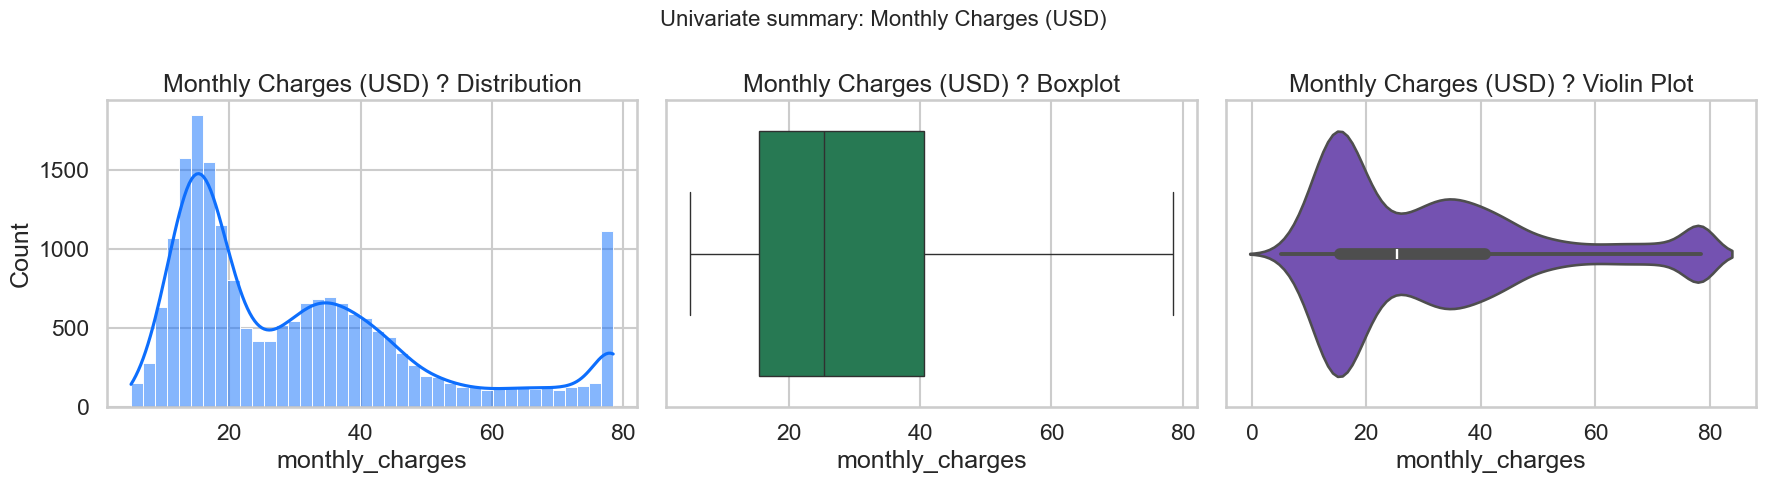

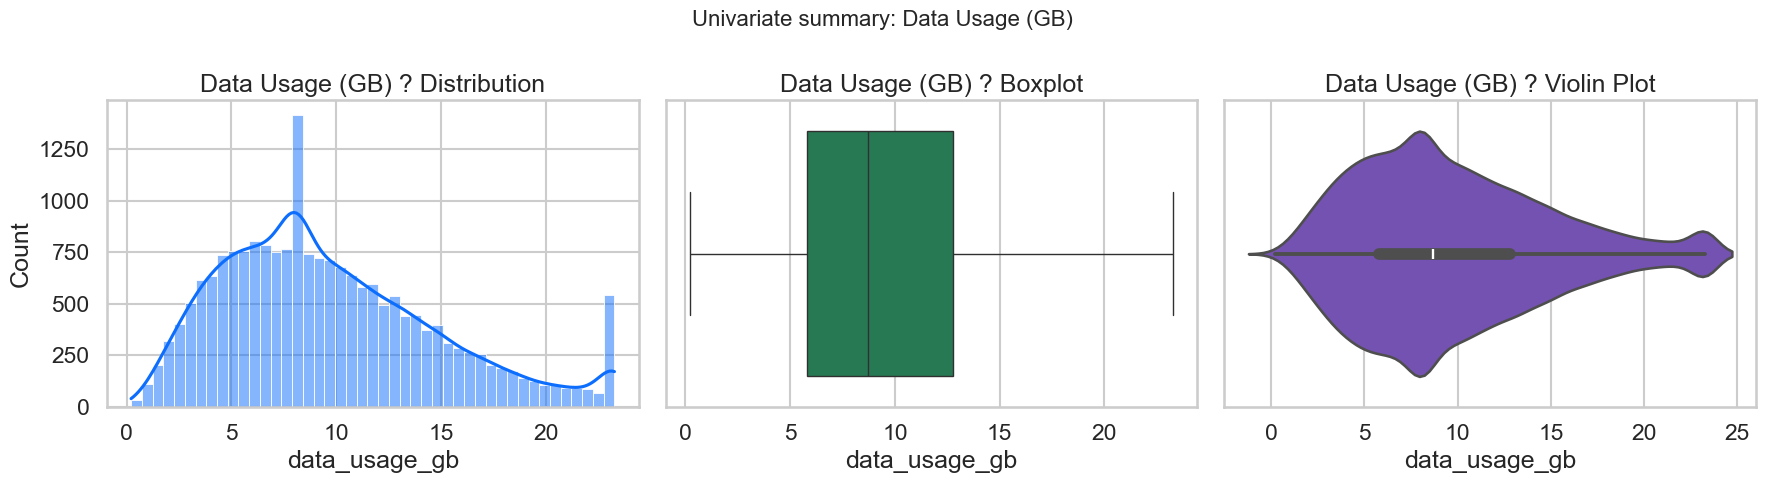

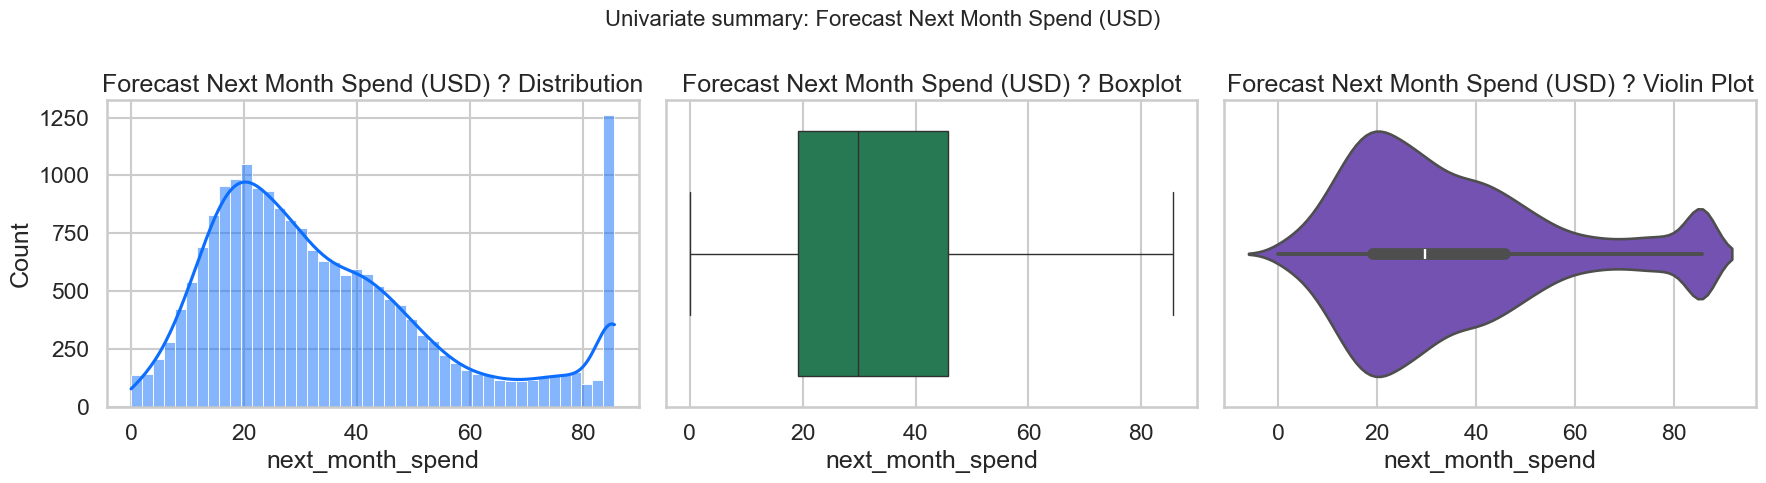

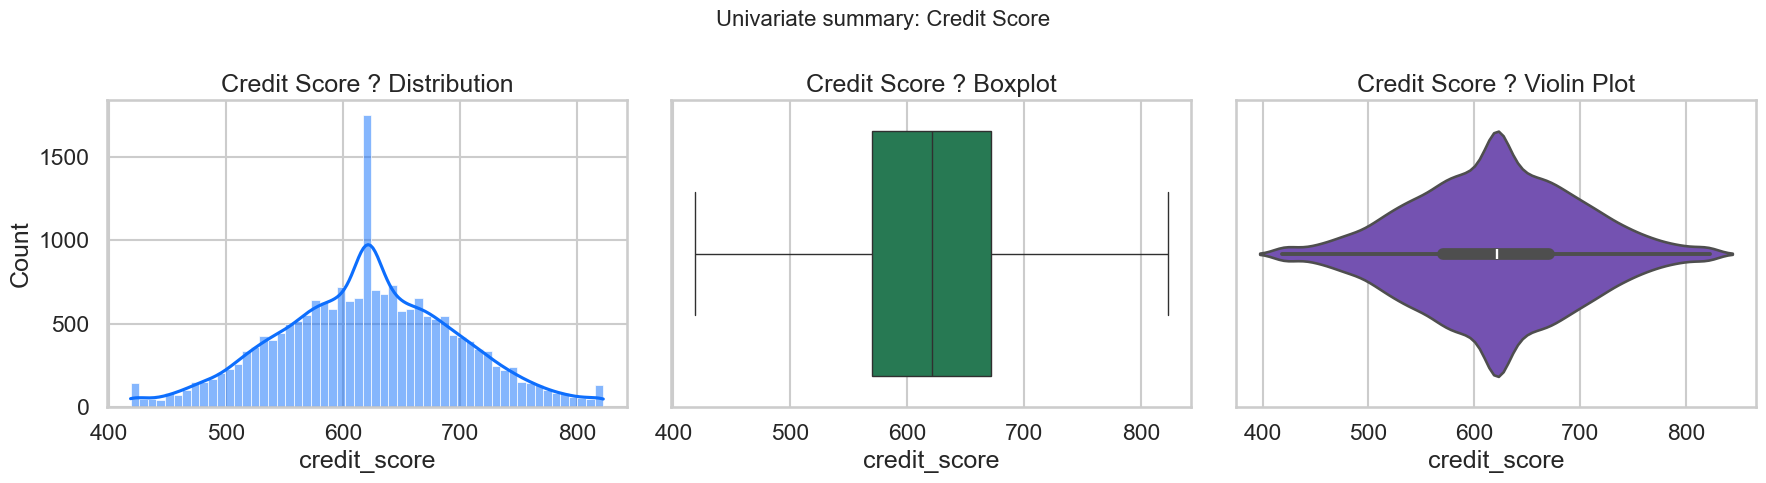

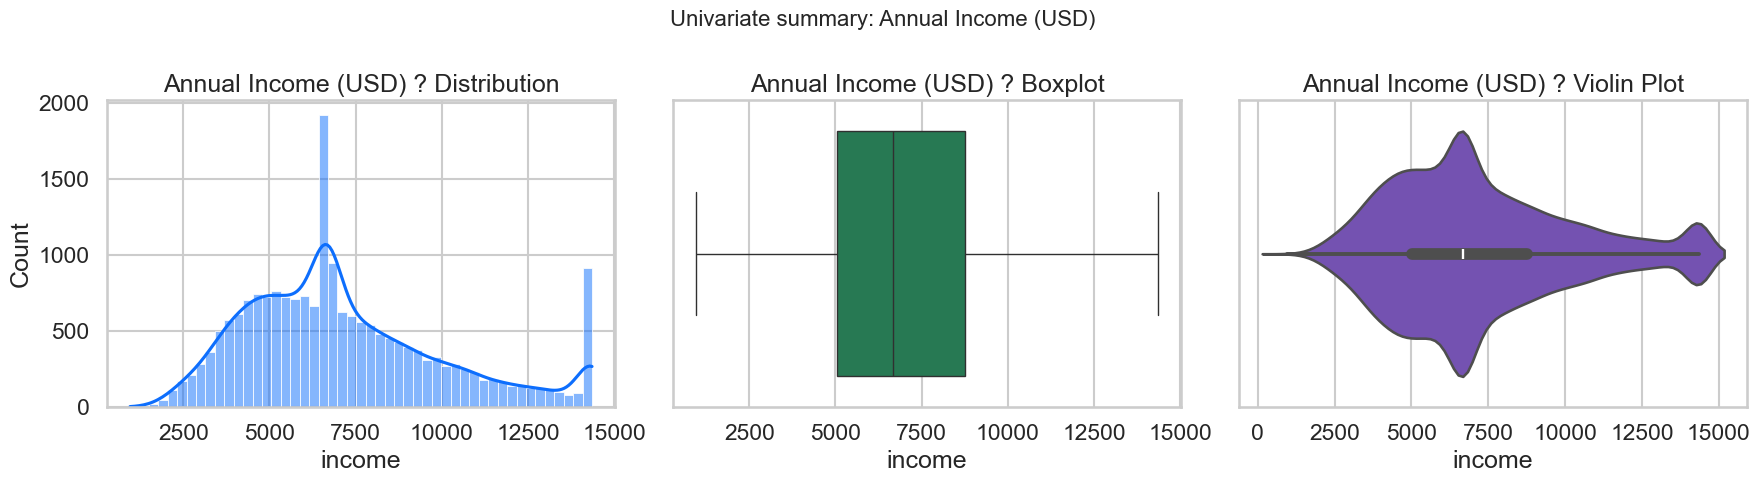

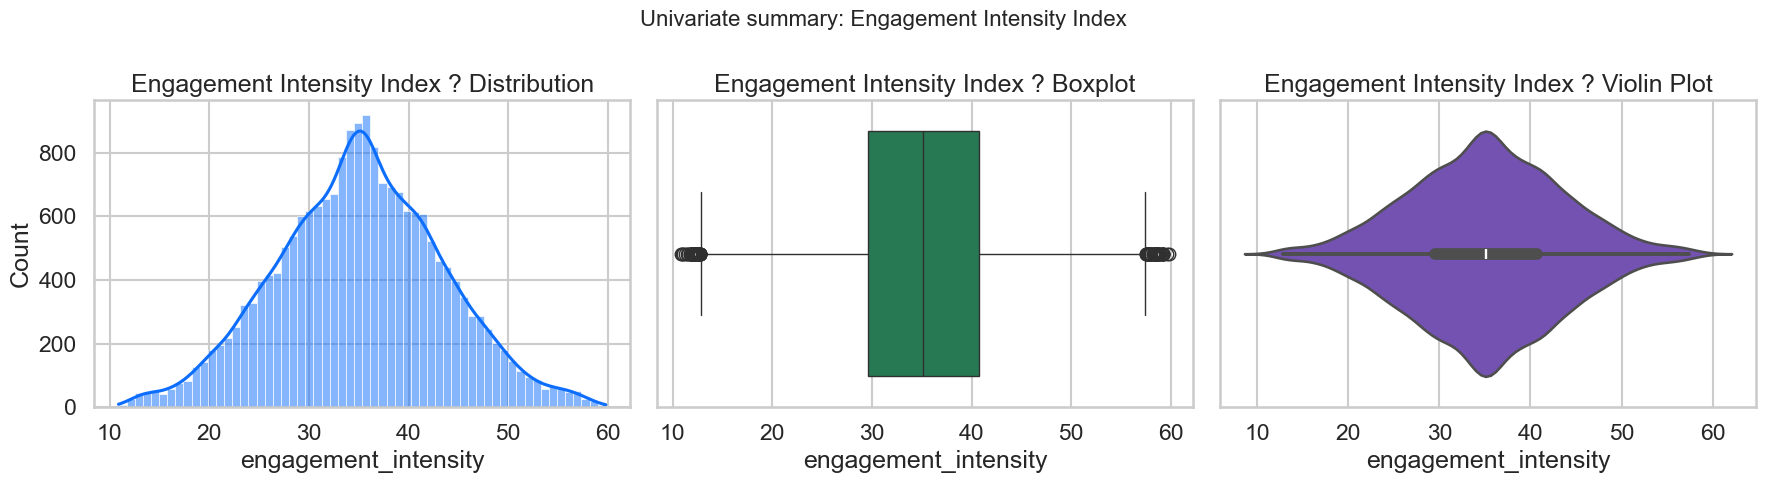

In [6]:

univariate_features = {
    'monthly_charges': 'Monthly Charges (USD)',
    'data_usage_gb': 'Data Usage (GB)',
    'next_month_spend': 'Forecast Next Month Spend (USD)',
    'credit_score': 'Credit Score',
    'income': 'Annual Income (USD)',
    'engagement_intensity': 'Engagement Intensity Index'
}

for feature, label in univariate_features.items():
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    sns.histplot(clean_df[feature], kde=True, ax=axes[0], color='#0d6efd')
    axes[0].set_title(f'{label} ? Distribution')
    sns.boxplot(x=clean_df[feature], ax=axes[1], color='#198754')
    axes[1].set_title(f'{label} ? Boxplot')
    sns.violinplot(x=clean_df[feature], ax=axes[2], color='#6f42c1')
    axes[2].set_title(f'{label} ? Violin Plot')
    fig.suptitle(f'Univariate summary: {label}', fontsize=16)
    plt.tight_layout()
    fig_path = FIGURES_DIR / f'univariate_{feature}.png'
    fig.savefig(fig_path, dpi=300)
    plt.show()


C:\Users\kkadema.SIRDC\AppData\Local\Temp\ipykernel_28184\4180807881.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, ax=ax, palette='flare')


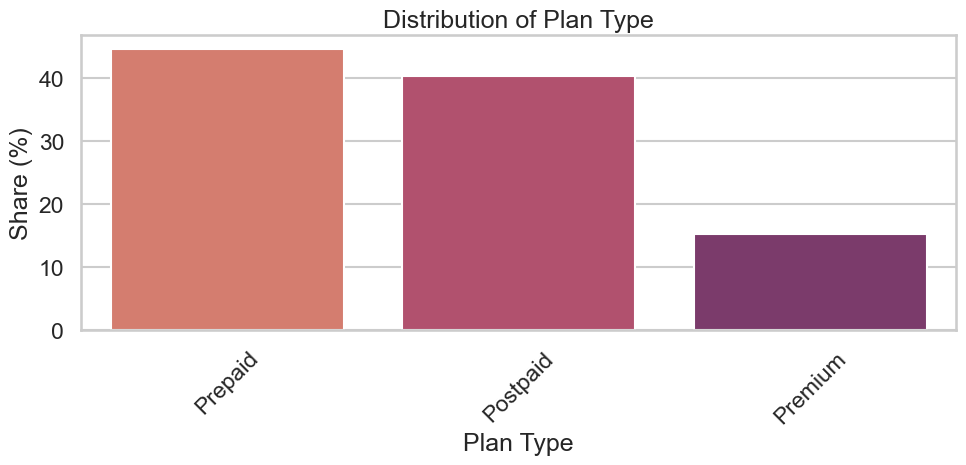

C:\Users\kkadema.SIRDC\AppData\Local\Temp\ipykernel_28184\4180807881.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, ax=ax, palette='flare')


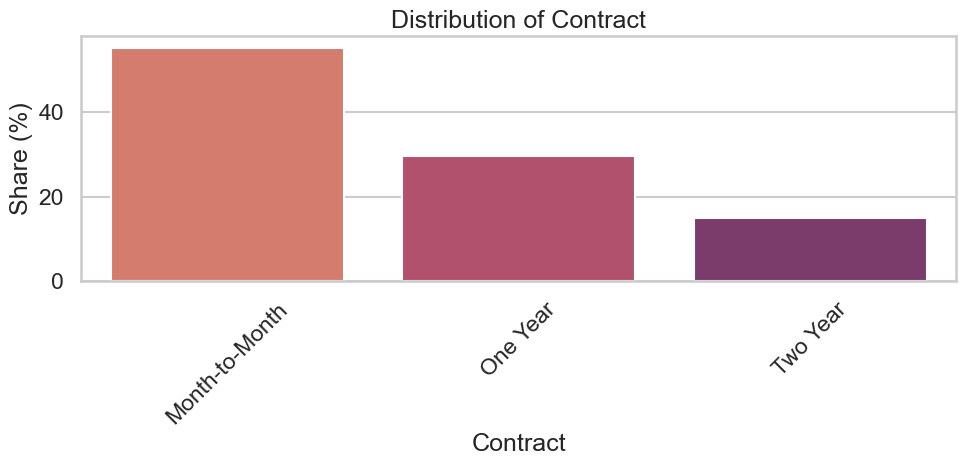

C:\Users\kkadema.SIRDC\AppData\Local\Temp\ipykernel_28184\4180807881.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, ax=ax, palette='flare')


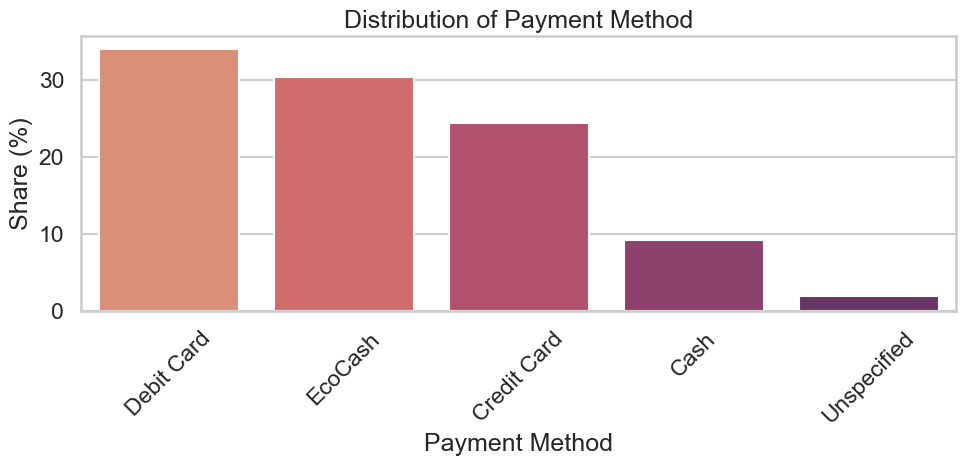

C:\Users\kkadema.SIRDC\AppData\Local\Temp\ipykernel_28184\4180807881.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, ax=ax, palette='flare')


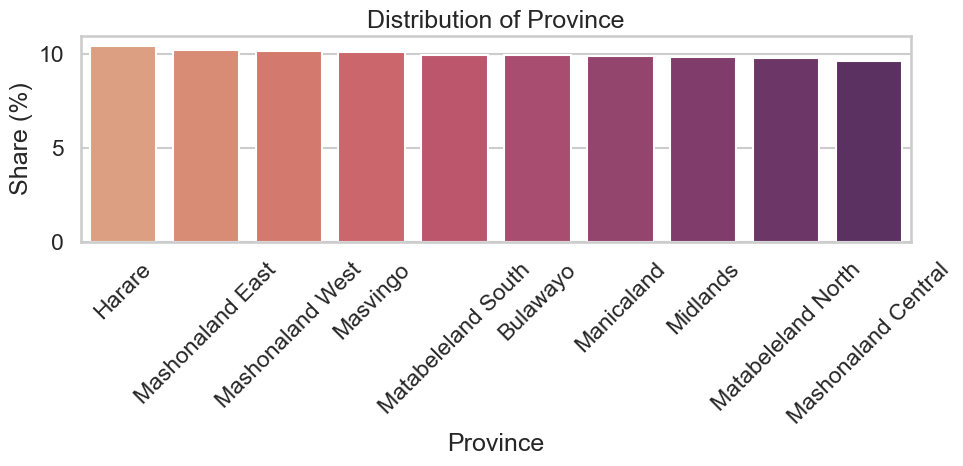

C:\Users\kkadema.SIRDC\AppData\Local\Temp\ipykernel_28184\4180807881.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, ax=ax, palette='flare')


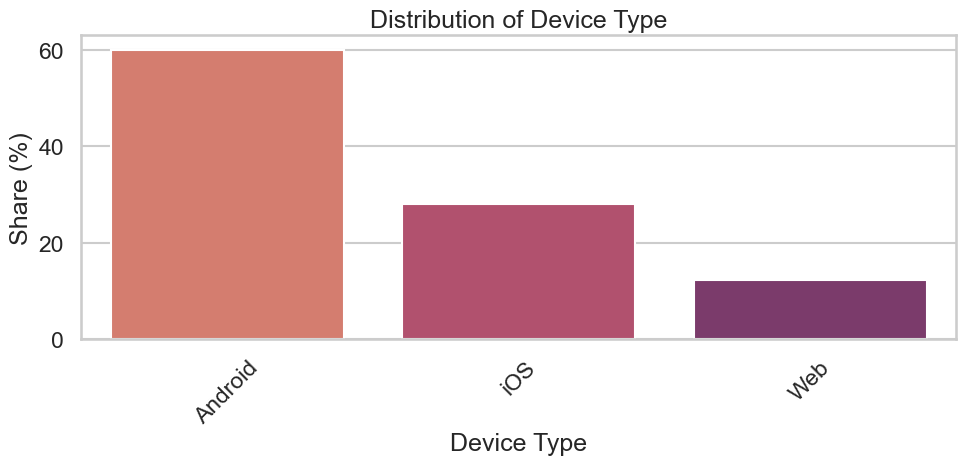

In [7]:

categorical_features = ['plan_type', 'contract', 'payment_method', 'province', 'device_type']
for feature in categorical_features:
    counts = clean_df[feature].value_counts(normalize=True).sort_values(ascending=False) * 100
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.barplot(x=counts.index, y=counts.values, ax=ax, palette='flare')
    ax.set_ylabel('Share (%)')
    ax.set_xlabel(feature.replace('_', ' ').title())
    ax.set_title(f"Distribution of {feature.replace('_', ' ').title()}")
    ax.tick_params(axis='x', rotation=45)
    plt.tight_layout()
    fig_path = FIGURES_DIR / f'categorical_{feature}.png'
    fig.savefig(fig_path, dpi=300)
    plt.show()



## 3. Bivariate relationships


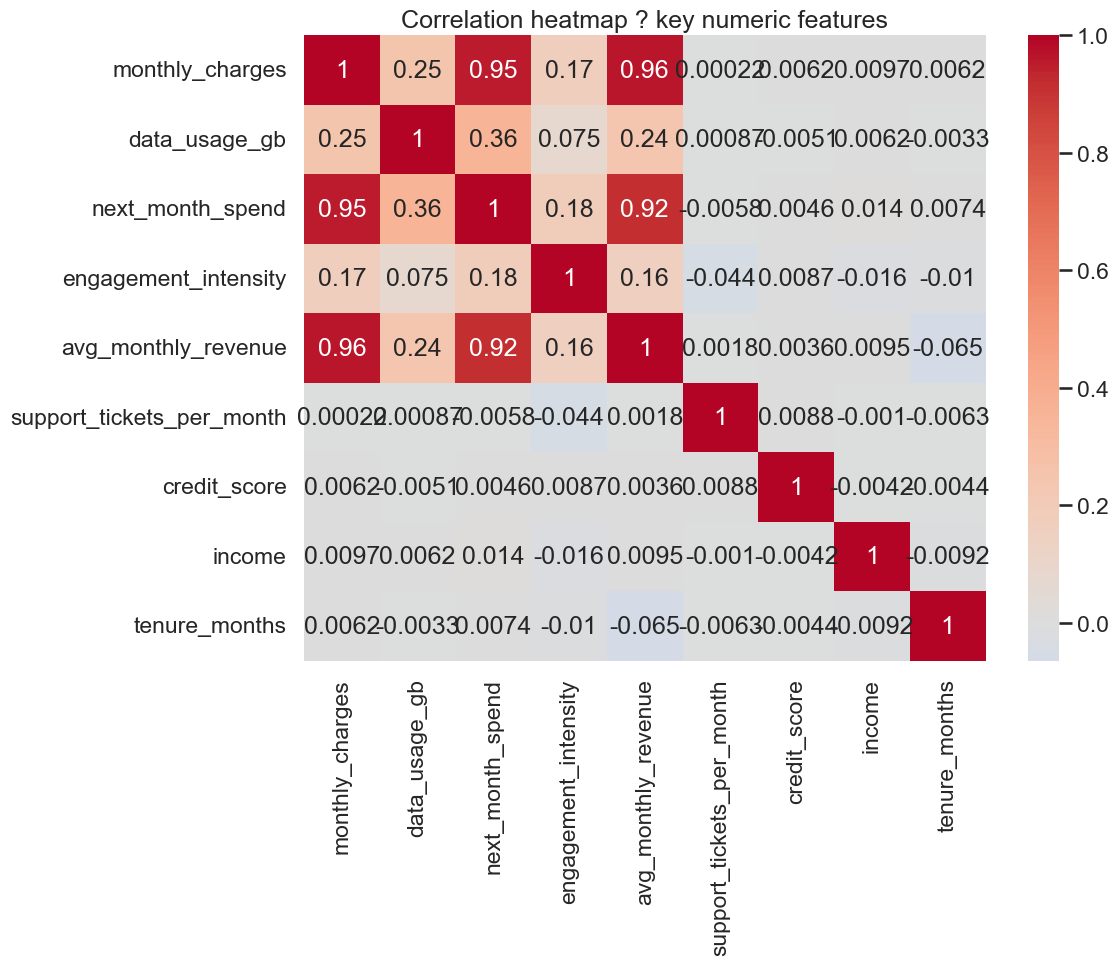

In [8]:

analysis_columns = [
    'monthly_charges',
    'data_usage_gb',
    'next_month_spend',
    'engagement_intensity',
    'avg_monthly_revenue',
    'support_tickets_per_month',
    'credit_score',
    'income',
    'tenure_months'
]

corr = clean_df[analysis_columns].corr()
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, ax=ax)
ax.set_title('Correlation heatmap ? key numeric features')
plt.tight_layout()
fig_path = FIGURES_DIR / 'correlation_heatmap.png'
fig.savefig(fig_path, dpi=300)
plt.show()


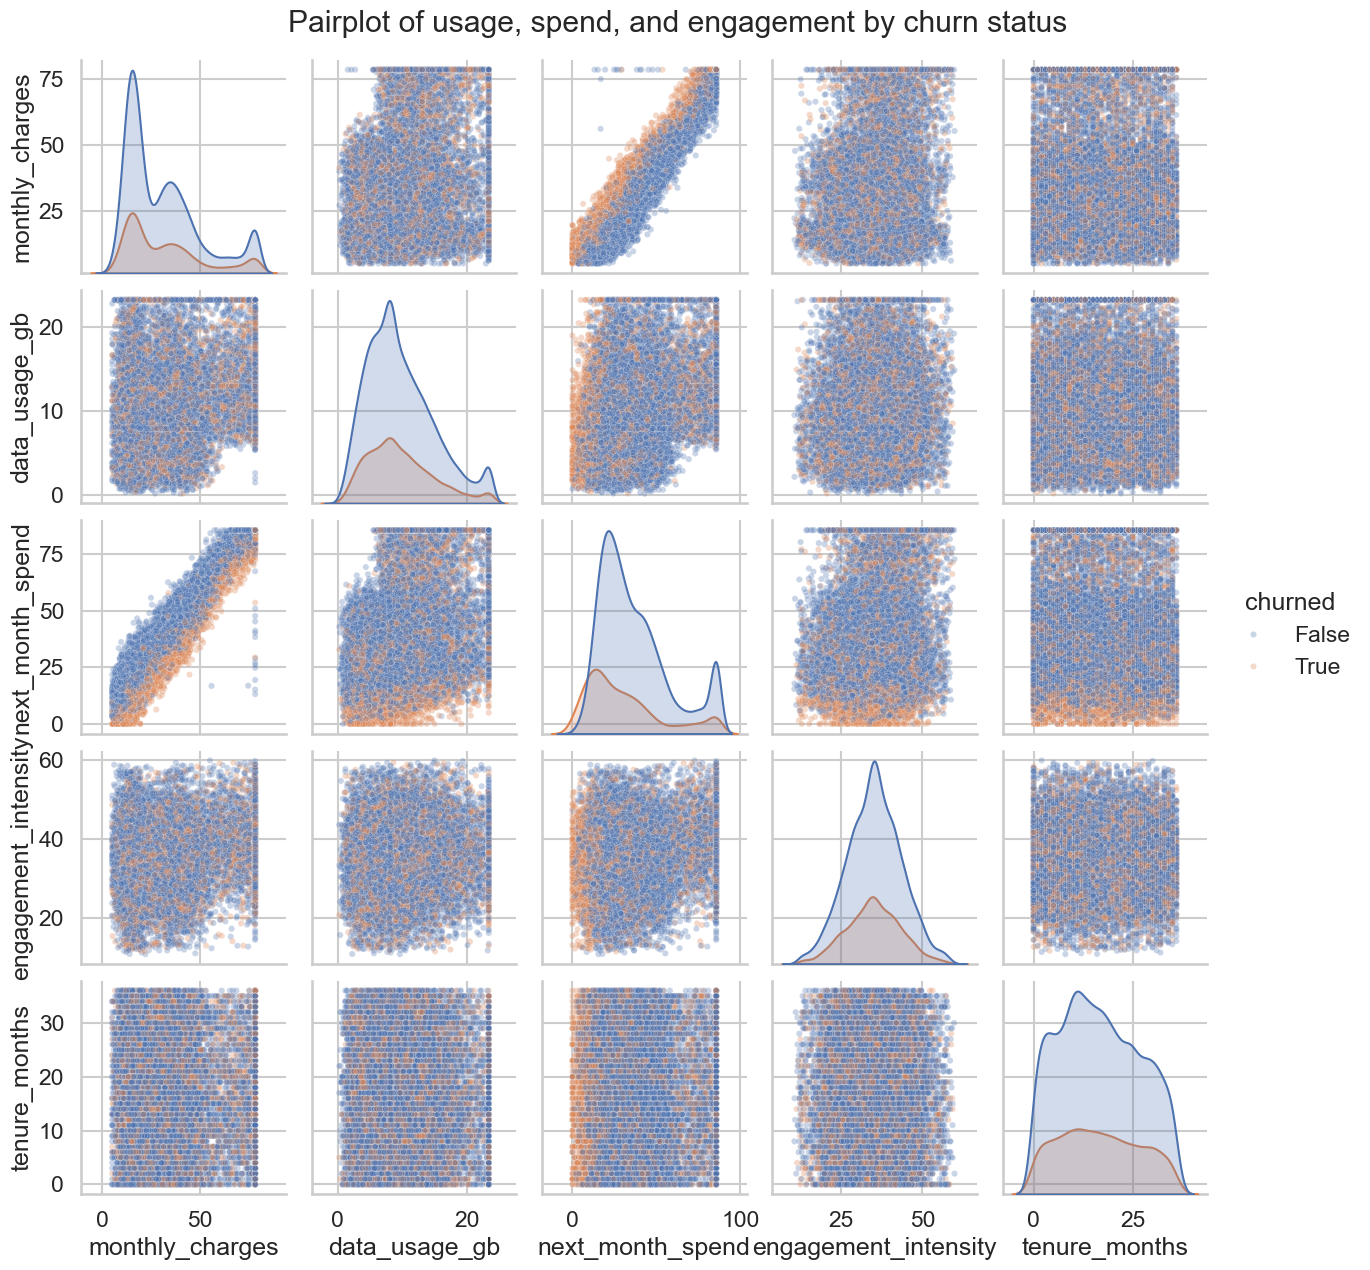

In [9]:

pairplot_features = ['monthly_charges', 'data_usage_gb', 'next_month_spend', 'engagement_intensity', 'tenure_months']
pairplot = sns.pairplot(
    clean_df[pairplot_features + ['churned']],
    vars=pairplot_features,
    hue='churned',
    plot_kws={'alpha': 0.3, 's': 20},
    diag_kind='kde'
)
pairplot.fig.suptitle('Pairplot of usage, spend, and engagement by churn status', y=1.02)
fig_path = FIGURES_DIR / 'pairplot_usage_spend_churn.png'
pairplot.savefig(fig_path, dpi=300)
plt.show()


C:\Users\kkadema.SIRDC\AppData\Local\Temp\ipykernel_28184\3170065410.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=clean_df, x='churned', y='next_month_spend', palette='Set2')
C:\Users\kkadema.SIRDC\AppData\Local\Temp\ipykernel_28184\3170065410.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Active', 'Churned'])


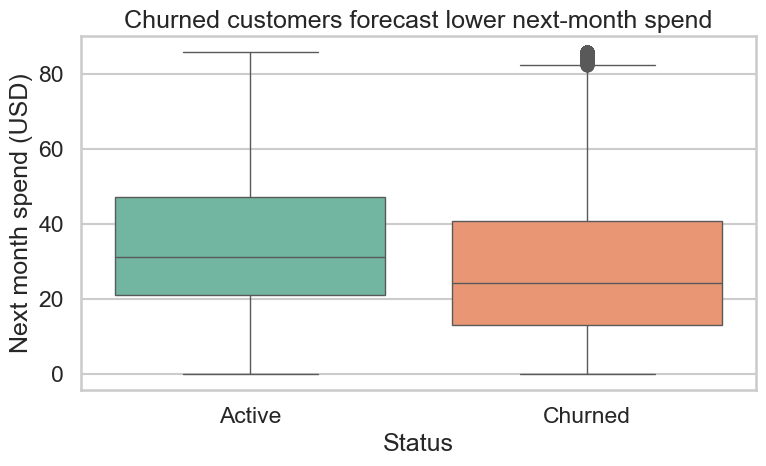

In [10]:

fig, ax = plt.subplots(figsize=(8, 5))
sns.boxplot(data=clean_df, x='churned', y='next_month_spend', palette='Set2')
ax.set_xticklabels(['Active', 'Churned'])
ax.set_xlabel('Status')
ax.set_ylabel('Next month spend (USD)')
ax.set_title('Churned customers forecast lower next-month spend')
plt.tight_layout()
fig_path = FIGURES_DIR / 'box_next_spend_by_churn.png'
fig.savefig(fig_path, dpi=300)
plt.show()


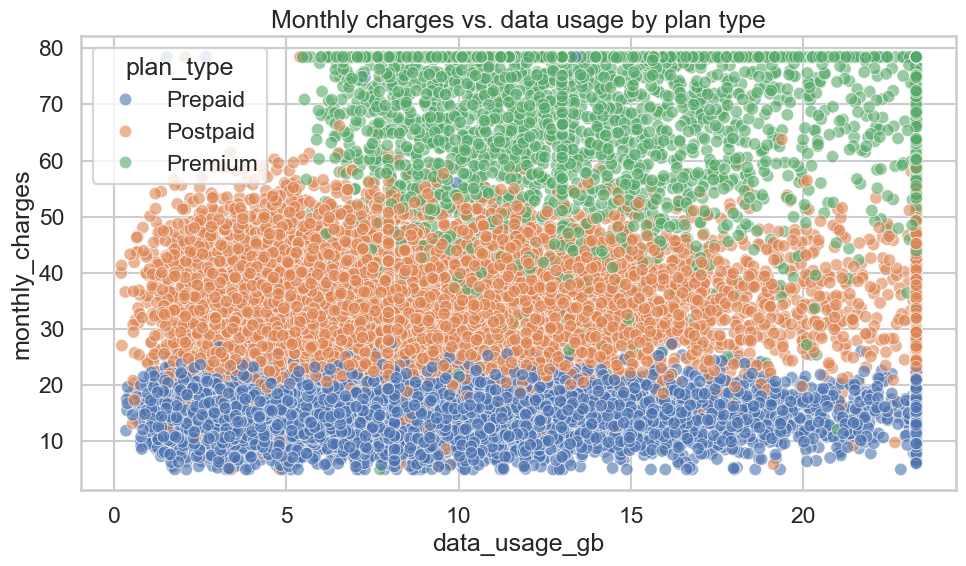

In [11]:

fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(
    data=clean_df,
    x='data_usage_gb',
    y='monthly_charges',
    hue='plan_type',
    alpha=0.6,
    ax=ax
)
ax.set_title('Monthly charges vs. data usage by plan type')
plt.tight_layout()
fig_path = FIGURES_DIR / 'scatter_usage_vs_charges_plan.png'
fig.savefig(fig_path, dpi=300)
plt.show()


C:\Users\kkadema.SIRDC\AppData\Local\Temp\ipykernel_28184\155443820.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=churn_by_plan.index, y=churn_by_plan.values, palette='magma', ax=ax)


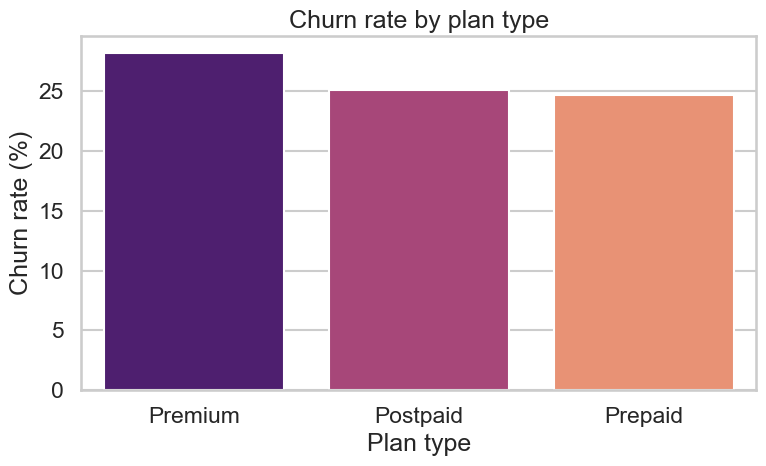

In [12]:

churn_by_plan = clean_df.groupby('plan_type')['churned'].mean().sort_values(ascending=False) * 100
fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(x=churn_by_plan.index, y=churn_by_plan.values, palette='magma', ax=ax)
ax.set_ylabel('Churn rate (%)')
ax.set_xlabel('Plan type')
ax.set_title('Churn rate by plan type')
plt.tight_layout()
fig_path = FIGURES_DIR / 'bar_churn_by_plan.png'
fig.savefig(fig_path, dpi=300)
plt.show()


C:\Users\kkadema.SIRDC\AppData\Local\Temp\ipykernel_28184\756624367.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=app_churn.index, y=app_churn.values, palette='deep', ax=ax)


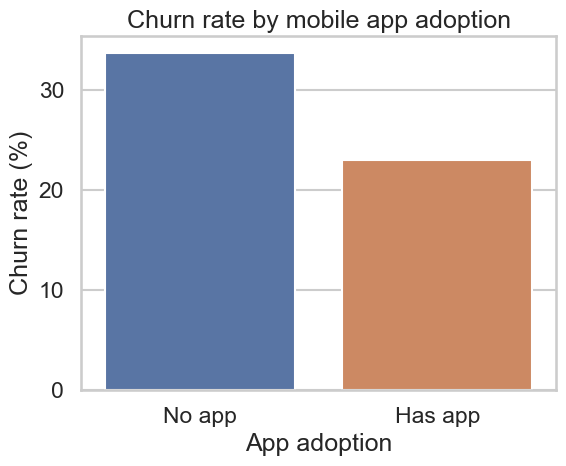

In [13]:

app_churn = (
    clean_df.assign(has_app_label=clean_df['has_app'].map({True: 'Has app', False: 'No app'}))
    .groupby('has_app_label')['churned']
    .mean()
    .sort_values(ascending=False) * 100
)
fig, ax = plt.subplots(figsize=(6, 5))
sns.barplot(x=app_churn.index, y=app_churn.values, palette='deep', ax=ax)
ax.set_ylabel('Churn rate (%)')
ax.set_xlabel('App adoption')
ax.set_title('Churn rate by mobile app adoption')
plt.tight_layout()
fig_path = FIGURES_DIR / 'bar_churn_by_app.png'
fig.savefig(fig_path, dpi=300)
plt.show()


C:\Users\kkadema.SIRDC\AppData\Local\Temp\ipykernel_28184\3505043973.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  support_churn = clean_df.groupby(support_bins)['churned'].mean() * 100
C:\Users\kkadema.SIRDC\AppData\Local\Temp\ipykernel_28184\3505043973.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=support_churn.index, y=support_churn.values, ax=ax, palette='cividis')


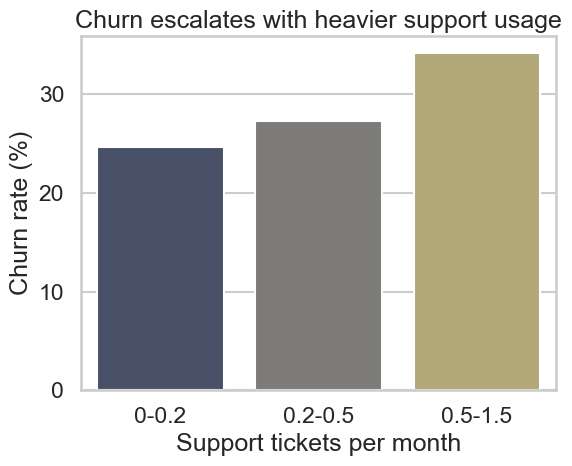

In [14]:

support_bins = pd.cut(
    clean_df['support_tickets_per_month'],
    bins=[0, 0.2, 0.5, 1.5],
    labels=['0-0.2', '0.2-0.5', '0.5-1.5'],
    include_lowest=True
)
support_churn = clean_df.groupby(support_bins)['churned'].mean() * 100
fig, ax = plt.subplots(figsize=(6, 5))
sns.barplot(x=support_churn.index, y=support_churn.values, ax=ax, palette='cividis')
ax.set_ylabel('Churn rate (%)')
ax.set_xlabel('Support tickets per month')
ax.set_title('Churn escalates with heavier support usage')
plt.tight_layout()
fig_path = FIGURES_DIR / 'bar_churn_by_support.png'
fig.savefig(fig_path, dpi=300)
plt.show()


C:\Users\kkadema.SIRDC\AppData\Local\Temp\ipykernel_28184\299642370.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=revenue_by_payment.index, y=revenue_by_payment.values, ax=ax, palette='rocket')


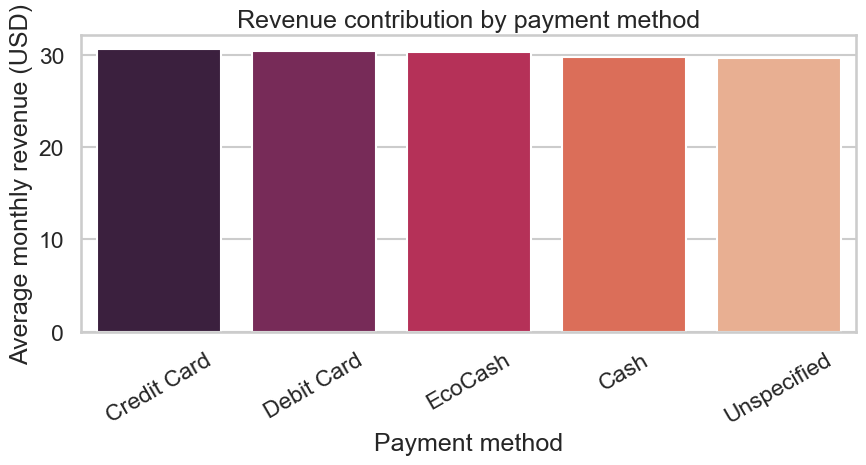

In [15]:

revenue_by_payment = clean_df.groupby('payment_method')['avg_monthly_revenue'].mean().sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(9, 5))
sns.barplot(x=revenue_by_payment.index, y=revenue_by_payment.values, ax=ax, palette='rocket')
ax.set_ylabel('Average monthly revenue (USD)')
ax.set_xlabel('Payment method')
ax.set_title('Revenue contribution by payment method')
ax.tick_params(axis='x', rotation=30)
plt.tight_layout()
fig_path = FIGURES_DIR / 'bar_revenue_by_payment.png'
fig.savefig(fig_path, dpi=300)
plt.show()



## 4. Temporal dynamics


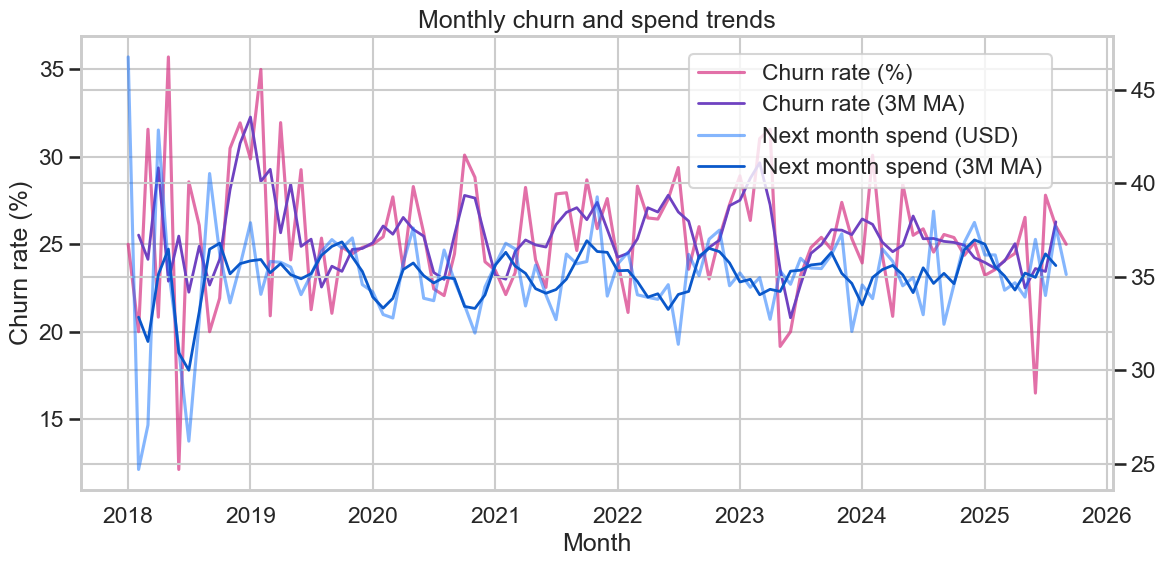

In [16]:

monthly_metrics = (
    clean_df.assign(month=clean_df['last_seen'].dt.to_period('M'))
    .groupby('month')
    .agg({
        'churned': 'mean',
        'next_month_spend': 'mean',
        'data_usage_gb': 'mean'
    })
    .reset_index()
)
monthly_metrics['month'] = monthly_metrics['month'].dt.to_timestamp()
monthly_metrics['churned_ma'] = monthly_metrics['churned'].rolling(window=3, center=True).mean()
monthly_metrics['spend_ma'] = monthly_metrics['next_month_spend'].rolling(window=3, center=True).mean()

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(monthly_metrics['month'], monthly_metrics['churned'] * 100, label='Churn rate (%)', color='#d63384', alpha=0.7)
ax.plot(monthly_metrics['month'], monthly_metrics['churned_ma'] * 100, label='Churn rate (3M MA)', color='#6f42c1', linewidth=2)
ax.set_ylabel('Churn rate (%)')
ax2 = ax.twinx()
ax2.plot(monthly_metrics['month'], monthly_metrics['next_month_spend'], label='Next month spend (USD)', color='#0d6efd', alpha=0.5)
ax2.plot(monthly_metrics['month'], monthly_metrics['spend_ma'], label='Next month spend (3M MA)', color='#0a58ca', linewidth=2)
ax.set_title('Monthly churn and spend trends')
ax.set_xlabel('Month')
fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9))
plt.tight_layout()
fig_path = FIGURES_DIR / 'temporal_churn_spend.png'
fig.savefig(fig_path, dpi=300)
plt.show()


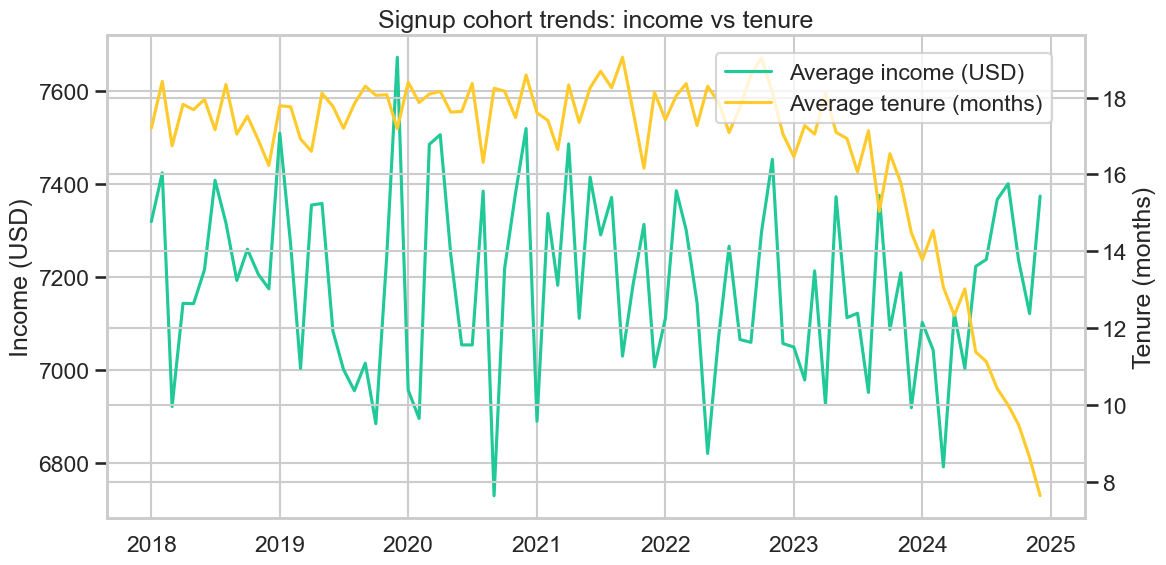

In [17]:

signup_cohort = (
    clean_df.assign(signup_month=clean_df['signup_date'].dt.to_period('M'))
    .groupby('signup_month')
    .agg(avg_income=('income', 'mean'), avg_tenure=('tenure_months', 'mean'))
    .reset_index()
)
signup_cohort['signup_month'] = signup_cohort['signup_month'].dt.to_timestamp()
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(signup_cohort['signup_month'], signup_cohort['avg_income'], color='#20c997', label='Average income (USD)')
ax1.set_ylabel('Income (USD)')
ax2 = ax1.twinx()
ax2.plot(signup_cohort['signup_month'], signup_cohort['avg_tenure'], color='#ffca2c', label='Average tenure (months)')
ax2.set_ylabel('Tenure (months)')
ax1.set_title('Signup cohort trends: income vs tenure')
fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9))
plt.tight_layout()
fig_path = FIGURES_DIR / 'temporal_signup_income_tenure.png'
fig.savefig(fig_path, dpi=300)
plt.show()



## 5. Spatial insights


C:\Users\kkadema.SIRDC\AppData\Local\Temp\ipykernel_28184\2640158448.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=province_churn, x='province', y='churned', palette='plasma', ax=ax)


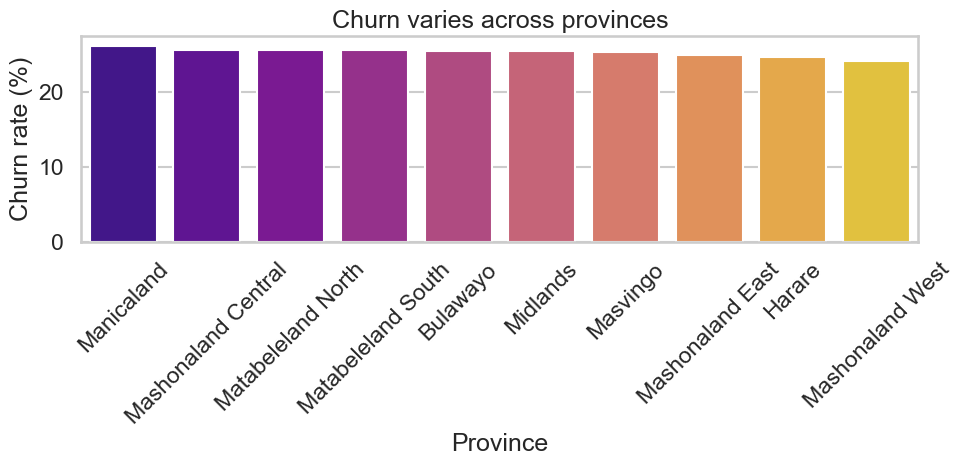

In [18]:

province_churn = (
    clean_df.groupby('province')['churned']
    .mean()
    .mul(100)
    .reset_index()
    .sort_values('churned', ascending=False)
)
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(data=province_churn, x='province', y='churned', palette='plasma', ax=ax)
ax.set_ylabel('Churn rate (%)')
ax.set_xlabel('Province')
ax.set_title('Churn varies across provinces')
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
fig_path = FIGURES_DIR / 'bar_churn_by_province.png'
fig.savefig(fig_path, dpi=300)
plt.show()


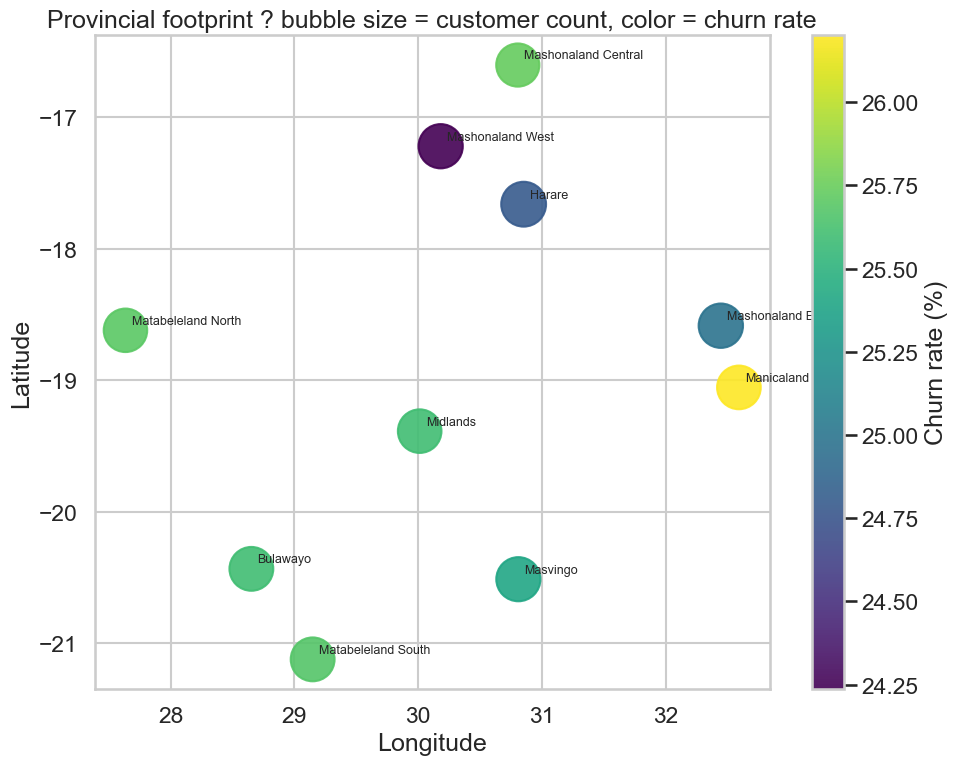

In [19]:

geo_df = gpd.GeoDataFrame(
    clean_df,
    geometry=gpd.points_from_xy(clean_df['lng'], clean_df['lat']),
    crs='EPSG:4326'
)
province_summary = geo_df.groupby('province').agg({
    'customer_id': 'count',
    'churned': 'mean',
    'next_month_spend': 'mean',
    'engagement_intensity': 'mean',
    'geometry': 'first'
}).reset_index()
province_summary = gpd.GeoDataFrame(province_summary, geometry='geometry', crs='EPSG:4326')
province_summary['churned_pct'] = province_summary['churned'] * 100
province_summary['lon'] = province_summary.geometry.x
province_summary['lat'] = province_summary.geometry.y

fig, ax = plt.subplots(figsize=(10, 8))
scatter = ax.scatter(
    province_summary['lon'],
    province_summary['lat'],
    s=province_summary['customer_id'] * 0.5,
    c=province_summary['churned_pct'],
    cmap='viridis',
    alpha=0.9
)
for _, row in province_summary.iterrows():
    ax.text(row['lon'] + 0.05, row['lat'] + 0.05, row['province'], fontsize=9)
ax.set_title('Provincial footprint ? bubble size = customer count, color = churn rate')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
fig.colorbar(scatter, label='Churn rate (%)')
plt.tight_layout()
fig_path = FIGURES_DIR / 'spatial_province_bubble.png'
fig.savefig(fig_path, dpi=300)
plt.show()


In [20]:

map_center = [geo_df['lat'].mean(), geo_df['lng'].mean()]
engagement_map = folium.Map(location=map_center, zoom_start=6)

for _, row in province_summary.iterrows():
    folium.CircleMarker(
        location=[row['geometry'].y, row['geometry'].x],
        radius=5 + row['customer_id'] / 800,
        weight=1,
        color='#0d6efd',
        fill=True,
        fill_color='#0d6efd',
        fill_opacity=0.6,
        popup=(
            f"<b>{row['province']}</b><br>Customers: {row['customer_id']:,}<br>"
            f"Churn rate: {row['churned_pct']:.1f}%<br>"
            f"Avg spend: <br>"
            f"Engagement: {row['engagement_intensity']:.1f}"
        )
    ).add_to(engagement_map)

map_path = PROJECT_ROOT / 'reports' / 'geo_customer_engagement.html'
engagement_map.save(map_path)
map_path


WindowsPath('C:/Users/kkadema.SIRDC/Desktop/data analysis/data_science_project/reports/geo_customer_engagement.html')


## 6. Distribution diagnostics


In [21]:

dist_features = ['monthly_charges', 'data_usage_gb', 'next_month_spend', 'credit_score', 'income', 'engagement_intensity']
dist_rows = []
for feature in dist_features:
    series = clean_df[feature]
    skew = series.skew()
    kurt = series.kurtosis()
    stat, pvalue = stats.normaltest(series)
    if pvalue < 0.05:
        shape = 'non-normal'
    else:
        shape = 'approximately normal'
    dist_rows.append({
        'feature': feature,
        'skewness': skew,
        'kurtosis': kurt,
        'normaltest_pvalue': pvalue,
        'distribution_shape': shape
    })

dist_summary = pd.DataFrame(dist_rows).set_index('feature')
dist_summary


skewness  kurtosis  normaltest_pvalue distribution_shape
feature                                                                       
monthly_charges       1.050075  0.216596           0.000000         non-normal
data_usage_gb         0.727894  0.048158           0.000000         non-normal
next_month_spend      0.923470  0.081854           0.000000         non-normal
credit_score         -0.002946 -0.088262           0.029388         non-normal
income                0.776387  0.066949           0.000000         non-normal
engagement_intensity  0.006660 -0.105308           0.005641         non-normal

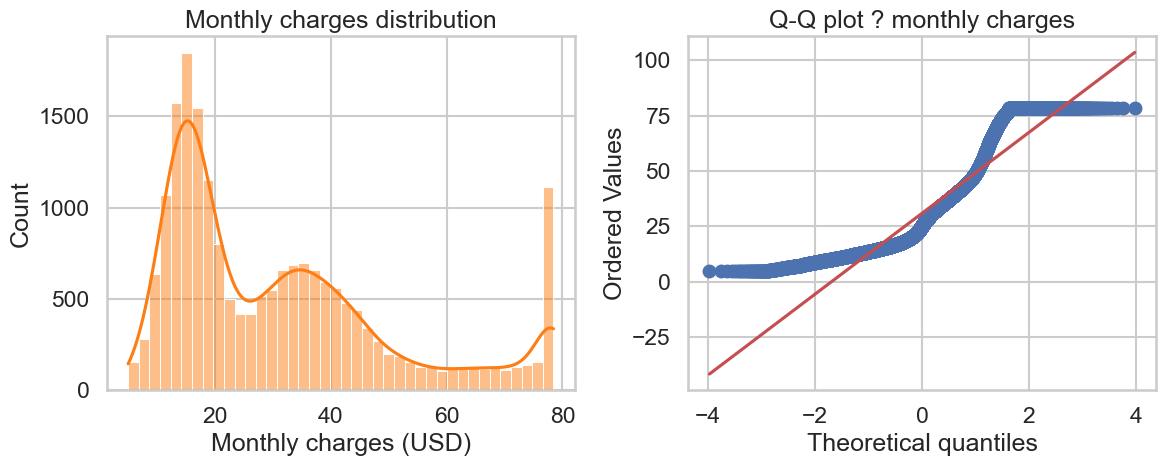

In [22]:

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(clean_df['monthly_charges'], kde=True, ax=ax[0], color='#fd7e14')
ax[0].set_title('Monthly charges distribution')
ax[0].set_xlabel('Monthly charges (USD)')

stats.probplot(clean_df['monthly_charges'], dist='norm', plot=ax[1])
ax[1].set_title('Q-Q plot ? monthly charges')
plt.tight_layout()
fig_path = FIGURES_DIR / 'distribution_monthly_charges.png'
fig.savefig(fig_path, dpi=300)
plt.show()



## 7. Key observations

*High-level insights captured in the accompanying insights deck summarize the most material patterns discovered here.*
